# Text classification with Pytorch

The goal of this TP is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to IMDB data - and then compare to models implemented in the previous TPs. 

In [1]:
import torch
import torch.nn as nn

## 1 - A (very small) introduction to pytorch

Pytorch Tensors are very similar to Numpy arrays, with the added benefit of being usable on GPU. For a short tutorial on various methods to create tensors of particular types, see [this link](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).
The important things to note are that Tensors can be created empty, from lists, and it is very easy to convert a numpy array into a pytorch tensor, and inversely.

In [ ]:
a = torch.LongTensor(5)
b = torch.LongTensor([5])

print(a)
print(b)

tensor([          103836736,                  27,          4294967295,
        4908972153413002606, 7214836307739637349])
tensor([5])


In [ ]:
a = torch.FloatTensor([2])
b = torch.FloatTensor([3])

print(a + b)

tensor([5.])


The main interest in us using Pytorch is the ```autograd``` package. ```torch.Tensor```objects have an attribute ```.requires_grad```; if set as True, it starts to track all operations on it. When you finish your computation, can call ```.backward()``` and all the gradients are computed automatically (and stored in the ```.grad``` attribute).

One way to easily cut a tensor from the computational once it is not needed anymore is to use ```.detach()```.
More info on automatic differentiation in pytorch on [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).


In [ ]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2 
print(w.grad)    # w.grad = 1 
print(b.grad)    # b.grad = 1 

tensor(2.)
tensor(1.)
tensor(1.)


In [ ]:
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = nn.Linear(3, 2)
for name, p in linear.named_parameters():
    print(name)
    print(p)

# Build loss function - Mean Square Error
criterion = nn.MSELoss()

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('Initial loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

weight
Parameter containing:
tensor([[-0.0719, -0.4977, -0.5126],
        [ 0.1109,  0.0859,  0.3049]], requires_grad=True)
bias
Parameter containing:
tensor([-0.3251,  0.1173], requires_grad=True)
Initial loss:  1.5052385330200195
dL/dw:  tensor([[ 0.1128, -1.0629,  0.2693],
        [-0.2046, -0.1202,  0.5515]])
dL/db:  tensor([-0.0847,  0.0387])


In [ ]:
# You can perform gradient descent manually, with an in-place update ...
linear.weight.data.sub_(0.01 * linear.weight.grad.data)
linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after one update: ', loss.item())

Loss after one update:  1.489516258239746


In [ ]:
# Use the optim package to define an Optimizer that will update the weights of the model.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# By default, gradients are accumulated in buffers( i.e, not overwritten) whenever .backward()
# is called. Before the backward pass, we need to use the optimizer object to zero all of the
# gradients.
optimizer.zero_grad()
loss.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

# Print out the loss after the second step of gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after two updates: ', loss.item())

Loss after two updates:  1.4742602109909058


## 2 - Tools for data processing 

```torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit ```Dataset``` and override the following methods:
- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get the i-th sample

Here is a toy example: 

In [ ]:
toy_corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
              'I walk down the the avenue']

toy_categories = [0, 0, 1, 0, 0]

In [2]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # A pytorch dataset class for holding data for a text classification task.
    def __init__(self, data, categories):
        # Upon creating the Dataset object, store the data in an attribute
        # Split the text data and labels from each other
        self.X, self.Y = [], []
        for x, y in zip(data, categories):
            # We will propably need to preprocess the data - have it done in a separate method
            # We do it here because we might need corpus-wide info to do the preprocessing 
            # For example, cutting all examples to the same length
            self.X.append(self.preprocess(x))
            self.Y.append(y)
                
    # Method allowing you to preprocess data                      
    def preprocess(self, text):
        text_pp = text.lower().strip()
        return text_pp
    
    # Overriding the method __len__ so that len(CustomDatasetName) returns the number of data samples                     
    def __len__(self):
        return len(self.Y)
   
    # Overriding the method __getitem__ so that CustomDatasetName[i] returns the i-th sample of the dataset                      
    def __getitem__(self, idx):
           return self.X[idx], self.Y[idx]

In [ ]:
toy_dataset = CustomDataset(toy_corpus, toy_categories)

In [ ]:
print(len(toy_dataset))
for i in range(len(toy_dataset)):
    print(toy_dataset[i])

5
('i walked down down the boulevard', 0)
('i walked down the avenue', 0)
('i ran down the boulevard', 1)
('i walk down the city', 0)
('i walk down the the avenue', 0)


```torch.utils.data.DataLoader``` is what we call an iterator, which provides very useful features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.
and can be created very simply from a ```Dataset```. Continuing on our simple example: 

In [ ]:
toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True)

In [ ]:
for e in range(3):
    print("Epoch:" + str(e))
    for x, y in toy_dataloader:
        print("Batch: " + str(x) + "; labels: " + str(y))  

Epoch:0
Batch: ('i walked down the avenue', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walked down down the boulevard', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i walk down the the avenue',); labels: tensor([0])
Epoch:1
Batch: ('i walk down the the avenue', 'i walked down down the boulevard'); labels: tensor([0, 0])
Batch: ('i walk down the city', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walked down the avenue',); labels: tensor([0])
Epoch:2
Batch: ('i walk down the city', 'i walked down the avenue'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard', 'i walked down down the boulevard'); labels: tensor([1, 0])
Batch: ('i walk down the the avenue',); labels: tensor([0])


## 3 - Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (use what we saw in the previous TP)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

In [3]:
import os
import sys
import os.path as op
from torch.nn import functional as F
import numpy as np
import random

from nltk import word_tokenize
from torch.nn.utils.rnn import pad_sequence

First, we get the filenames and the corresponding categories: 

In [4]:
# For those on google colab: you can download the files directly with this:
import gdown
gdown.download("http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", output="aclImdb_v1.tar.gz", quiet=False)
!tar xzf /content/aclImdb_v1.tar.gz

Downloading...
From: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
To: /content/aclImdb_v1.tar.gz
100%|██████████| 84.1M/84.1M [00:07<00:00, 11.1MB/s]


In [5]:
from glob import glob
# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'train', 'pos', '*.txt')))

test_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'test', 'neg', '*.txt')))
test_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'test', 'pos', '*.txt')))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

test_texts_neg = [open(f, encoding="utf8").read() for f in test_filenames_neg]
test_texts_pos = [open(f, encoding="utf8").read() for f in test_filenames_pos]
test_texts = test_texts_neg + test_texts_pos


# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=int)
train_labels[:len(train_texts_neg)] = 0.


test_labels = np.ones(len(test_texts), dtype=int)
test_labels[:len(test_texts_neg)] = 0.

Example of one document:

In [ ]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

We can use a function from sklearn, ```train_test_split```, to separate data into training and validation sets:



In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

We can now implement our ```TextClassificationDataset``` class, that we will build from:
- A list of path to the IMDB files in the training set: ```path_to_file```
- A list of the corresponding categories: ```categories```
We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the validation and training ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 100 by default.
- Lastly, a ```min_freq``` that indicates how many times a word must appear to be taken in the vocabulary. 

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0. 

In [ ]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [ ]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


In [ ]:
from typing import List, Dict

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, data: List[str], categories, vocab = None, max_length = 100, min_freq = 5):
        self.data = data      
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
        
        # We then need to tokenize the data .. 
        tokenized_data = [word_tokenize(text) for text in self.data]
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data = [[self.word2idx.get(word, self.word2idx['UNK']) for word in text] for text in tokenized_data]
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(data) for data in indexed_data]
        # And the categories into a FloatTensor
        tensor_y = torch.FloatTensor(categories)
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [data[:max_length] for data in tensor_data]
        
        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension 
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, count_threshold):
        """
        Same as in the previous TP: we want to output word_index, a dictionary containing words 
        and their corresponding indexes as {word : indexes} 
        But we also want the reverse, which is a dictionary {indexes: word}
        Don't forget to add a UNK token that we need when encountering unknown words
        We also choose '0' to represent the padding index, so begin the vocabulary index at 1 ! 
        """
        word_counts = {}
        for document in corpus:
          for word in word_tokenize(document):
            if not word in word_counts.keys():
              word_counts[word] = 1
            else:
              word_counts[word] += 1
        word_idx = {}                   
        idx = 1
        for (word, count) in word_counts.items():
          if count >= count_threshold:
            word_idx[word] = idx
            idx += 1
        word_idx['UNK'] = idx

        idx_word = {}
        for (word, idx) in word_idx.items():
          idx_word[idx] = word
        return word_idx, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
train_labels_splt

array([1, 1, 1, ..., 0, 0, 1])

In [ ]:
training_dataset = TextClassificationDataset(train_texts_splt, train_labels_splt)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [ ]:
valid_dataset = TextClassificationDataset(val_texts, val_labels, (training_word2idx, training_idx2word))

In [ ]:
test_dataset = TextClassificationDataset(test_texts, test_labels, (training_word2idx, training_idx2word))

In [ ]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [ ]:
print(valid_dataset[1])

(tensor([  534,   534,   534,   534,   534, 10478,  9848,   534,   534,   534,
          534,   534,   358,   359,   360,   361,   358,   359,   360,   361,
          227,   299,  4456,   263,   233,  3168, 10940,    16,   448,   872,
         4568,   694,    40,   421,   316,    64,  3263,   233,  3283,    64,
        21182, 11592, 13647,   233,   358,   359,   360,   361,   358,   359,
          360,   361,  3283,     8,   936,   587,  5844,   144,   145,    22,
         1472,    40,    64,  1783,   179,   261,  4746,    97,    22,   902,
           67,   448,  6024,   941,    19,   104,    35,     2,  1615,    67,
          149,    32,   429,   321,     8,     4,  7470, 14169,     5, 11570,
           28, 13527,    16, 15818,   362,  2706,    16,    19,   509,  1088]), tensor(1.))


In [ ]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 100])
torch.Size([200])


### 4 - A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class AveragingModel(nn.Module):    
    def __init__(self, embedding_dim, vocabulary_size):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(num_embeddings = vocabulary_size+1, embedding_dim = embedding_dim, padding_idx = 0)
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(embedding_dim, 1)
        
        # No need for sigmoid, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inputs shape is Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs).mean(axis = 1)
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze()
        return o

In [ ]:
import torch.optim as optim

In [ ]:
model = AveragingModel(300, len(training_word2idx))
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
criterion = nn.BCEWithLogitsLoss()

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model(x)
        # (2) Compute the loss 
        loss = criterion(pred,y)
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step()
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the sigmoid

        num_corrects = (torch.where(torch.sigmoid(pred)>=0.5, 1, 0) == y).sum()
        acc = 100.0 * num_corrects/len(y)
        
        if (i%20 == 0):
            print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
    return losses

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Same for the evaluation ! We don't need the optimizer here. 
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model(x)
            loss = criterion(pred,y)
            num_corrects = (torch.where(torch.sigmoid(pred)>=0.5, 1, 0) == y).sum()
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [ ]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, num_epochs = 5, early_stopping = True):
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses, test_acc

In [ ]:
train_losses, _= experiment(model, opt, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6934763193130493; training acc = 53.0
Batch 20 : training loss = 0.6776535511016846; training acc = 58.5
Batch 40 : training loss = 0.6441395282745361; training acc = 67.0
Batch 60 : training loss = 0.6109309792518616; training acc = 73.0
Batch 80 : training loss = 0.5904875993728638; training acc = 70.0
Epoch 1 : Validation loss = 0.571274623721838; Validation acc = 72.3
Epoch 2:
Batch 0 : training loss = 0.5554693341255188; training acc = 79.0
Batch 20 : training loss = 0.5221799612045288; training acc = 76.0
Batch 40 : training loss = 0.4816991686820984; training acc = 79.5
Batch 60 : training loss = 0.46717584133148193; training acc = 78.5
Batch 80 : training loss = 0.4345765709877014; training acc = 83.5
Epoch 2 : Validation loss = 0.4512462331354618; Validation acc = 79.8
Epoch 3:
Batch 0 : training loss = 0.3551620543003082; training acc = 87.5
Batch 20 : training loss = 0.35592517256736755; training acc = 87.5
Batch 40 

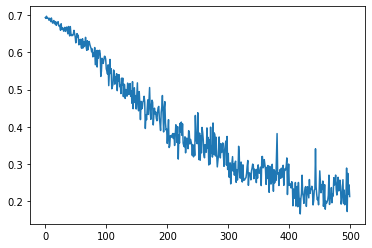

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

### With Glove embeddings: 

Now, we would like to integrate pre-trained word embeddings into our model ! Let's use again the functions that we used in the previous lab:

In [ ]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

In [ ]:
dir(loaded_glove_model)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_load_specials',
 '_log_evaluate_word_analogies',
 '_save_specials',
 '_smart_save',
 'accuracy',
 'add',
 'closer_than',
 'cosine_similarities',
 'distance',
 'distances',
 'doesnt_match',
 'evaluate_word_analogies',
 'evaluate_word_pairs',
 'get_keras_embedding',
 'get_vector',
 'index2entity',
 'index2word',
 'init_sims',
 'load',
 'load_word2vec_format',
 'log_accuracy',
 'log_evaluate_word_pairs',
 'most_similar',
 'most_similar_cosmul',
 'most_similar_to_given',
 'n_similarity',
 'rank',
 'save',
 'save_word2vec_format',
 'similar_by_vector',
 's

In [ ]:
loaded_glove_model.vocab.get('a').index

7

In [ ]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [ ]:
print(GloveEmbeddings.shape)
# We should check that the "padding" vector is at zero
print(GloveEmbeddings[0])

(31808, 300)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not ! 

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
class PretrainedAveragingModel(nn.Module):
  def __init__(self, pretrained_embeddings, requires_grad: bool):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding.from_pretrained(embeddings = pretrained_embeddings).requires_grad_(requires_grad)
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(pretrained_embeddings.shape[1], 1)
        
        # No need for sigmoid, it will be into the criterion ! 
        
  def forward(self, inputs):
      # Remember: the inputs shape is Batch_size * seq_length * embedding_dim
      # First, take the mean of the embeddings of the document
      x = self.embeddings(inputs).mean(axis = 1)
      # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
      o = self.linear(x).squeeze()
      return o

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ?
- Make hypothesis based on your intuition and the class on how the size of the vocabulary (change the minimum frequency of words to be taken in the vocabular) will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning).
- Verify experiments and analyze your results !

Without Fine-tuning

In [ ]:
model_withoutFineTuning = PretrainedAveragingModel(torch.FloatTensor(GloveEmbeddings), requires_grad=False)
opt_withoutFineTuning = optim.Adam(model_withoutFineTuning.parameters(), lr=0.0025, betas=(0.9, 0.999))

In [ ]:
train_losses,_ = experiment(model_withoutFineTuning, opt_withoutFineTuning, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.69260573387146; training acc = 52.0
Batch 20 : training loss = 0.6844608187675476; training acc = 59.0
Batch 40 : training loss = 0.6646459698677063; training acc = 61.5
Batch 60 : training loss = 0.6636707186698914; training acc = 67.5
Batch 80 : training loss = 0.6589758396148682; training acc = 63.5
Epoch 1 : Validation loss = 0.6555708229541779; Validation acc = 63.74
Epoch 2:
Batch 0 : training loss = 0.6485419273376465; training acc = 66.5
Batch 20 : training loss = 0.6485151648521423; training acc = 64.0
Batch 40 : training loss = 0.6538522243499756; training acc = 62.0
Batch 60 : training loss = 0.6487113833427429; training acc = 62.0
Batch 80 : training loss = 0.6356081366539001; training acc = 65.0
Epoch 2 : Validation loss = 0.6340189188718796; Validation acc = 66.1
Epoch 3:
Batch 0 : training loss = 0.6242058277130127; training acc = 67.0
Batch 20 : training loss = 0.6417356133460999; training acc = 68.5
Batch 40 : 

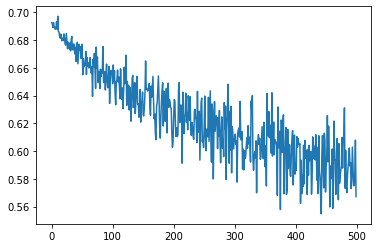

In [ ]:
plt.plot(train_losses)

In [ ]:
model_withFineTuning = PretrainedAveragingModel(torch.FloatTensor(GloveEmbeddings), requires_grad=True)
opt_withFineTuning = optim.Adam(model_withFineTuning.parameters(), lr=0.0025, betas=(0.9, 0.999))

In [ ]:
train_losses,_ = experiment(model_withFineTuning, opt_withFineTuning, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6949684619903564; training acc = 48.0
Batch 20 : training loss = 0.6725999712944031; training acc = 67.0
Batch 40 : training loss = 0.642730176448822; training acc = 66.5
Batch 60 : training loss = 0.595162034034729; training acc = 75.0
Batch 80 : training loss = 0.5720991492271423; training acc = 75.0
Epoch 1 : Validation loss = 0.5277802106738091; Validation acc = 75.86
Epoch 2:
Batch 0 : training loss = 0.4998961389064789; training acc = 80.5
Batch 20 : training loss = 0.4566391110420227; training acc = 81.5
Batch 40 : training loss = 0.4497455358505249; training acc = 82.0
Batch 60 : training loss = 0.3524833023548126; training acc = 87.5
Batch 80 : training loss = 0.38667282462120056; training acc = 83.0
Epoch 2 : Validation loss = 0.41696009069681167; Validation acc = 81.62
Epoch 3:
Batch 0 : training loss = 0.3373531997203827; training acc = 87.0
Batch 20 : training loss = 0.29384657740592957; training acc = 89.5
Batch 4

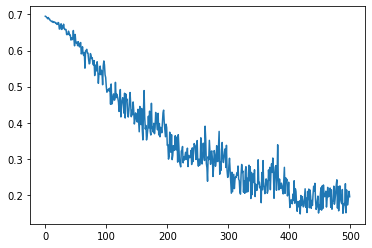

In [ ]:
plt.plot(train_losses)

Therefore, the test accuracy with fine-tuning is higher than the one without fine-tuning.

Hypothesis: text with vocabulary of higher threshold will reduce the vocabulary size hence contain less information, and vice versa. However, according to Zipf's law, lowering the threshold will stop improving the result till some point, because those vocabulary will become extremely rare in the text hence contain little information.

In [ ]:
def generate_data(min_freq):
  train_data = TextClassificationDataset(train_texts_splt, train_labels_splt, min_freq=min_freq) 
  train_word2idx, train_idx2word = train_data.get_vocab()
  valid_data = TextClassificationDataset(val_texts, val_labels, (train_word2idx, train_idx2word), min_freq=min_freq) 
  test_data = TextClassificationDataset(test_texts, test_labels, (train_word2idx, train_idx2word), min_freq=min_freq) 
  return train_data, valid_data, test_data, train_word2idx

def generate_GloveEmbeddings(train_word2idx):
  return get_glove_adapted_embeddings(loaded_glove_model, train_word2idx)

def experiment2(model, opt, criterion, train_dataloader, valid_dataloader, test_dataloader, num_epochs = 5, early_stopping = True):
  train_losses = []
  if early_stopping: 
      best_valid_loss = 10. 
  print("Beginning training...")
  for e in range(num_epochs):
      print("Epoch " + str(e+1) + ":")
      train_losses += train_epoch(model, opt, criterion, train_dataloader)
      valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
      print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
      if early_stopping:
          if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
          else:
              print("Early stopping.")
              break  
  test_loss, test_acc = eval_model(model, criterion, test_dataloader)
  print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
  return train_losses, test_acc

In [ ]:
train_data1, valid_data1, test_data1, train_word2idx = generate_data(1)

In [ ]:
GloveEmbeddings1 = generate_GloveEmbeddings(train_word2idx)

In [ ]:
train_dataloader = DataLoader(train_data1, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_data1, batch_size = 25)
test_dataloader = DataLoader(test_data1, batch_size = 25)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model1 = AveragingModel(300, len(train_word2idx))
opt1 = optim.Adam(model1.parameters(), lr = 0.0025, betas = (0.9, 0.999))
model2 = PretrainedAveragingModel(torch.FloatTensor(GloveEmbeddings1), requires_grad=False)
opt2 = optim.Adam(model2.parameters(), lr=0.0025, betas=(0.9, 0.999))
model3 = PretrainedAveragingModel(torch.FloatTensor(GloveEmbeddings1), requires_grad=True)
opt3 = optim.Adam(model3.parameters(), lr=0.0025, betas=(0.9, 0.999))

In [ ]:
_ = experiment2(model1, opt1, criterion, train_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6857811212539673; training acc = 57.5
Batch 20 : training loss = 0.678804337978363; training acc = 58.5
Batch 40 : training loss = 0.6549649238586426; training acc = 65.0
Batch 60 : training loss = 0.6232084631919861; training acc = 66.0
Batch 80 : training loss = 0.6199894547462463; training acc = 62.5
Epoch 1 : Validation loss = 0.5713502483069897; Validation acc = 72.7
Epoch 2:
Batch 0 : training loss = 0.5126262307167053; training acc = 82.0
Batch 20 : training loss = 0.533685564994812; training acc = 74.5
Batch 40 : training loss = 0.4716062545776367; training acc = 81.0
Batch 60 : training loss = 0.49501124024391174; training acc = 75.0
Batch 80 : training loss = 0.4296734631061554; training acc = 82.0
Epoch 2 : Validation loss = 0.44988244369626046; Validation acc = 80.08
Epoch 3:
Batch 0 : training loss = 0.3387790024280548; training acc = 89.0
Batch 20 : training loss = 0.33246710896492004; training acc = 89.0
Batch 40

In [ ]:
_ = experiment2(model2, opt2, criterion, train_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6902784705162048; training acc = 53.5
Batch 20 : training loss = 0.6819759607315063; training acc = 62.5
Batch 40 : training loss = 0.6680946350097656; training acc = 68.5
Batch 60 : training loss = 0.6668068766593933; training acc = 63.0
Batch 80 : training loss = 0.6585605144500732; training acc = 64.5
Epoch 1 : Validation loss = 0.6500131657719612; Validation acc = 65.4
Epoch 2:
Batch 0 : training loss = 0.6429851055145264; training acc = 69.5
Batch 20 : training loss = 0.6448109149932861; training acc = 67.5
Batch 40 : training loss = 0.6355626583099365; training acc = 67.0
Batch 60 : training loss = 0.6447816491127014; training acc = 63.0
Batch 80 : training loss = 0.6259084939956665; training acc = 70.5
Epoch 2 : Validation loss = 0.6279470634460449; Validation acc = 67.3
Epoch 3:
Batch 0 : training loss = 0.6097700595855713; training acc = 72.0
Batch 20 : training loss = 0.6412249803543091; training acc = 70.0
Batch 40 :

In [ ]:
_ = experiment2(model3, opt3, criterion, train_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.7032073736190796; training acc = 45.5
Batch 20 : training loss = 0.6728559732437134; training acc = 65.5
Batch 40 : training loss = 0.6517198085784912; training acc = 66.5
Batch 60 : training loss = 0.6255924105644226; training acc = 71.5
Batch 80 : training loss = 0.5895278453826904; training acc = 72.5
Epoch 1 : Validation loss = 0.5391955730319024; Validation acc = 75.36
Epoch 2:
Batch 0 : training loss = 0.515627384185791; training acc = 79.0
Batch 20 : training loss = 0.4956897497177124; training acc = 80.0
Batch 40 : training loss = 0.4586741328239441; training acc = 79.5
Batch 60 : training loss = 0.42906174063682556; training acc = 83.5
Batch 80 : training loss = 0.4252561330795288; training acc = 80.5
Epoch 2 : Validation loss = 0.4171526010334492; Validation acc = 81.62
Epoch 3:
Batch 0 : training loss = 0.3311728537082672; training acc = 85.5
Batch 20 : training loss = 0.27371692657470703; training acc = 91.5
Batch 4

In [ ]:
train_data2, valid_data2, test_data2, train_word2idx2 = generate_data(10)

In [ ]:
GloveEmbeddings2 = generate_GloveEmbeddings(train_word2idx2)

In [ ]:
train_dataloader2 = DataLoader(train_data2, batch_size = 200, shuffle=True)
valid_dataloader2 = DataLoader(valid_data2, batch_size = 25)
test_dataloader2 = DataLoader(test_data2, batch_size = 25)

In [ ]:
model1 = AveragingModel(300, len(train_word2idx2))
opt1 = optim.Adam(model1.parameters(), lr = 0.0025, betas = (0.9, 0.999))
model2 = PretrainedAveragingModel(torch.FloatTensor(GloveEmbeddings2), requires_grad=False)
opt2 = optim.Adam(model2.parameters(), lr=0.0025, betas=(0.9, 0.999))
model3 = PretrainedAveragingModel(torch.FloatTensor(GloveEmbeddings2), requires_grad=True)
opt3 = optim.Adam(model3.parameters(), lr=0.0025, betas=(0.9, 0.999))

In [ ]:
_ = experiment2(model1, opt1, criterion, train_dataloader2, valid_dataloader2, test_dataloader2)
_ = experiment2(model2, opt2, criterion, train_dataloader2, valid_dataloader2, test_dataloader2)
_ = experiment2(model3, opt3, criterion, train_dataloader2, valid_dataloader2, test_dataloader2)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6920394897460938; training acc = 52.0
Batch 20 : training loss = 0.6724687218666077; training acc = 62.5
Batch 40 : training loss = 0.6473925113677979; training acc = 66.0
Batch 60 : training loss = 0.6145668029785156; training acc = 70.0
Batch 80 : training loss = 0.5942036509513855; training acc = 70.5
Epoch 1 : Validation loss = 0.5634931924939156; Validation acc = 72.84
Epoch 2:
Batch 0 : training loss = 0.580030083656311; training acc = 74.5
Batch 20 : training loss = 0.5061113834381104; training acc = 75.0
Batch 40 : training loss = 0.4683142900466919; training acc = 78.0
Batch 60 : training loss = 0.42575764656066895; training acc = 85.5
Batch 80 : training loss = 0.4915919899940491; training acc = 76.5
Epoch 2 : Validation loss = 0.4532425111532211; Validation acc = 79.74
Epoch 3:
Batch 0 : training loss = 0.36850884556770325; training acc = 88.5
Batch 20 : training loss = 0.44089359045028687; training acc = 82.0
Batch 

Summary

| min freq                       | 1      | 5      | 10     |
|--------------------------------|--------|--------|--------|
| naive                          | 79.792 | 80.540 | 80.268 |
| pretrained without fine tuning | 73.124 | 70.416 | 70.688 |
| pretrained with fine tuning    | 79.564 | 80.136 | 80.456 |

From experiment we found that lowering threshold will improve the pretrained without find tunning method but doesn't influence much to the other two methods.


## 5 - Creating a LSTM model

In [ ]:
# Create a toy example of LSTM: 
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# LSTMs expect inputs having 3 dimensions:
# - The first dimension is the temporal dimension, along which we (in our case) have the different words
# - The second dimension is the batch dimension, along which we stack the independant batches
# - The third dimension is the feature dimension, along which are the features of the vector representing the words

# In our toy case, we have inputs and outputs containing 3 features (third dimension !)
# We created a sequence of 5 different inputs (first dimension !)
# We don't use batch (the second dimension will have one element)

# We need an initial hidden state, of the right sizes for dimension 2/3, but with only one temporal element:
# Here, it is:
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))
# Why do we create a tuple of two tensors ? Because we use LSTMs: remember that they use two sets of weights,
# and two hidden states (Hidden state, and Cell state).
# If you don't remember, read: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# If we used a classic RNN, we would simply have:
# hidden = torch.randn(1, 1, 3)

# The naive way of applying a lstm to inputs is to apply it one step at a time, and loop through the sequence
for i in inputs:
  # After each step, hidden contains the hidden states (remember, it's a tuple of two states).
  out, hidden = lstm(i.view(1, 1, -1), hidden)
    
# Alternatively, we can do the entire sequence all at once.
# The first value returned by LSTM is all of the Hidden states throughout the sequence.
# The second is just the most recent Hidden state and Cell state (you can compare the values)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence, for each temporal step
# "hidden" will allow you to continue the sequence and backpropagate later, with another sequence
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # Re-initialize
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[ 0.0543, -0.2970,  0.0012]],

        [[-0.0287,  0.0229,  0.0710]],

        [[ 0.0020, -0.0683,  0.1990]],

        [[-0.0054, -0.0306,  0.2377]],

        [[-0.0381, -0.0047,  0.2540]]], grad_fn=<StackBackward0>)
(tensor([[[-0.0381, -0.0047,  0.2540]]], grad_fn=<StackBackward0>), tensor([[[-0.0853, -0.0117,  0.7406]]], grad_fn=<StackBackward0>))


In [ ]:
print(i)
print(i.view(1,1,-1))

tensor([[-0.2940,  0.4556,  0.1856]])
tensor([[[-0.2940,  0.4556,  0.1856]]])


In [ ]:
training_dataset = TextClassificationDataset(train_texts_splt, train_labels_splt)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [ ]:
valid_dataset = TextClassificationDataset(val_texts, val_labels, (training_word2idx, training_idx2word))

In [ ]:
test_dataset = TextClassificationDataset(test_texts, test_labels, (training_word2idx, training_idx2word))

In [ ]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [ ]:
GloveEmbeddings = generate_GloveEmbeddings(training_word2idx)

We'll implement now a LSTM model, taking the same inputs and also outputing a score for the sentence.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class LSTMModel(nn.Module):
  def __init__(self, embedding_dim, vocabulary_size, hidden_dim, embeddings=None, fine_tuning=False):
    super().__init__()
    self.hidden_dim = hidden_dim
    if embeddings is not None:
      self.embedding = nn.Embedding.from_pretrained(embeddings).requires_grad_(fine_tuning)
    else:
      self.embedding = nn.Embedding(vocabulary_size+1, embedding_dim, padding_idx = 0)
    # input_size = number of features i,e, embedding_dim here
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True)
    self.linear = nn.Linear(hidden_dim, 1)
  def forward(self, inputs):
    # input.shape = (batch_size, seq_length)
    embeds = self.embedding(inputs)
    # embeds.shape = (batch_size, seq_length, input_size)
    # output vs h_n see https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm
    _, (h_n, _) = self.lstm(embeds)
    score = self.linear(h_n[-1]).squeeze() # since it is a one-layer lstm, the last layer is just the first layer
    # print(score.shape)
    return score


<div class='alert alert-block alert-warning'>
            Questions:</div>
            
- What do you see with a simple application of LSTM models ? List the possible reasons for that result (these could be linked to the data, the way it is pre-processed, the architecture, and the training procedure). 

In [ ]:
lstm_no_pretrained = LSTMModel(300, len(training_word2idx), 100)
opt_lstm_no_pretrained = optim.Adam(lstm_no_pretrained.parameters(), lr=0.0025, betas=(0.9,0.999))

In [ ]:
train_losses, _ = experiment2(lstm_no_pretrained, opt_lstm_no_pretrained, criterion, training_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6944324970245361; training acc = 53.0
Batch 20 : training loss = 0.6862580180168152; training acc = 55.0
Batch 40 : training loss = 0.6932951211929321; training acc = 55.0
Batch 60 : training loss = 0.684945285320282; training acc = 53.5
Batch 80 : training loss = 0.669968843460083; training acc = 57.0
Epoch 1 : Validation loss = 0.6770656058192253; Validation acc = 57.22
Epoch 2:
Batch 0 : training loss = 0.6542009711265564; training acc = 60.5
Batch 20 : training loss = 0.6325419545173645; training acc = 61.5
Batch 40 : training loss = 0.605177104473114; training acc = 68.0
Batch 60 : training loss = 0.6092445850372314; training acc = 69.0
Batch 80 : training loss = 0.5424492359161377; training acc = 76.0
Epoch 2 : Validation loss = 0.6485820643603801; Validation acc = 62.44
Epoch 3:
Batch 0 : training loss = 0.5434356927871704; training acc = 76.5
Batch 20 : training loss = 0.49144619703292847; training acc = 76.5
Batch 40 :

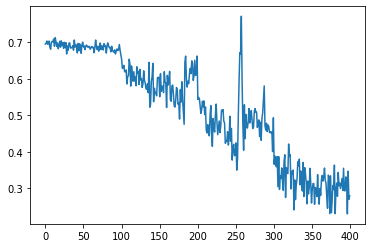

In [ ]:
plt.plot(train_losses)

In [ ]:
lstm_pretrained = LSTMModel(300, len(training_word2idx), 100, torch.FloatTensor(GloveEmbeddings))
opt_lstm_pretrained = optim.Adam(lstm_pretrained.parameters(), lr=0.0025, betas=(0.9,0.999))

In [ ]:
train_losses, _ = experiment2(lstm_pretrained, opt_lstm_pretrained, criterion, training_dataloader, valid_dataloader, test_dataloader, early_stopping = False)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.695645272731781; training acc = 46.0
Batch 20 : training loss = 0.6896180510520935; training acc = 53.5
Batch 40 : training loss = 0.6647027730941772; training acc = 61.0
Batch 60 : training loss = 0.6347398161888123; training acc = 65.0
Batch 80 : training loss = 0.6704243421554565; training acc = 55.5
Epoch 1 : Validation loss = 0.636068576425314; Validation acc = 65.44
Epoch 2:
Batch 0 : training loss = 0.5862404108047485; training acc = 70.5
Batch 20 : training loss = 0.5587217211723328; training acc = 69.0
Batch 40 : training loss = 0.578692615032196; training acc = 72.5
Batch 60 : training loss = 0.7075746655464172; training acc = 55.5
Batch 80 : training loss = 0.5878917574882507; training acc = 73.0
Epoch 2 : Validation loss = 0.5531611815094948; Validation acc = 73.52
Epoch 3:
Batch 0 : training loss = 0.5431809425354004; training acc = 75.0
Batch 20 : training loss = 0.5153287649154663; training acc = 76.0
Batch 40 : 

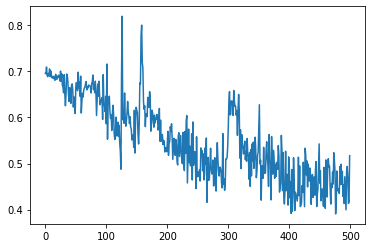

In [ ]:
plt.plot(train_losses)

In [ ]:
lstm_pretrained_fine_tuning = LSTMModel(300, len(training_word2idx), 100, torch.FloatTensor(GloveEmbeddings), fine_tuning=True)
opt_lstm_pretrained_fine_tuning = optim.Adam(lstm_pretrained_fine_tuning.parameters(), lr=0.0025, betas=(0.9,0.999))

In [ ]:
train_losses, _ = experiment2(lstm_pretrained_fine_tuning, opt_lstm_pretrained_fine_tuning, criterion, training_dataloader, valid_dataloader, test_dataloader, early_stopping = False)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6943264603614807; training acc = 46.5
Batch 20 : training loss = 0.6629374027252197; training acc = 64.0
Batch 40 : training loss = 0.5891351699829102; training acc = 67.5
Batch 60 : training loss = 0.473491907119751; training acc = 81.0
Batch 80 : training loss = 0.7622203230857849; training acc = 64.0
Epoch 1 : Validation loss = 0.6502965620160103; Validation acc = 66.42
Epoch 2:
Batch 0 : training loss = 0.6568790674209595; training acc = 62.5
Batch 20 : training loss = 0.5017474889755249; training acc = 79.0
Batch 40 : training loss = 0.6429032683372498; training acc = 63.0
Batch 60 : training loss = 0.6388832330703735; training acc = 68.0
Batch 80 : training loss = 0.5826309323310852; training acc = 72.0
Epoch 2 : Validation loss = 0.6238551804423332; Validation acc = 72.84
Epoch 3:
Batch 0 : training loss = 0.5351593494415283; training acc = 76.5
Batch 20 : training loss = 0.42372021079063416; training acc = 85.5
Batch 40

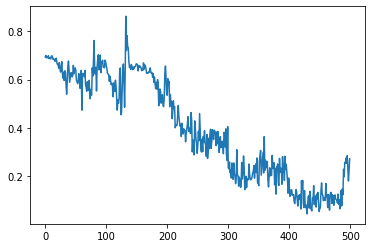

In [ ]:
plt.plot(train_losses)

Training RNN is slower than the previous model. For end-to-end training, we notice that the loss drops significantly between epochs. However in each epoch, the loss fluctuates more. For pretrained model without fine tuning, there is a flat stage of loss then the loss drops rapidly and oscillates wildly. For pretrained model with fine tuning, the loss behaviour is similar to end-to-end fashion but with less fluctuation. Also, the best test accuracy over these three model is achieved by the pretrained without fine tunning. But the other two models are not even better than the naive averaging model. The reasons may be: 1. we didn't benefit from the RNN architecture where it can process arbitrary length of sequence hence no need to padding or truncating, and this kind of preprocessing cannot help the model updating the embedding(we notice that both end-to-end and fine-tuning need update the embedding which result in a worse performance. 2. in previous methods, all embeddings has contributed to the score but here we only pick the last hidden state contributing to the score, maybe we are losing some information.

## 6 - Fine-tuning a Bert model

Fine-tune the lightest BERT model available on IMDB data and compare it with previous results ! You should simply follow the tutorial and slightly adapt it to our way of obtaining the data:
https://huggingface.co/docs/transformers/main/en/tasks/sequence_classification

In [8]:
!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 16.5 MB/s 
     |████████████████████████████████| 163 kB 62.5 MB/s 
     |████████████████████████████████| 7.6 MB 57.2 MB/s 


Actually refer to https://huggingface.co/transformers/v3.2.0/custom_datasets.html#fine-tuning-with-native-pytorch-tensorflow is more suitable to our case

<div class='alert alert-block alert-info'>
            Code:</div>

In [9]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
k = 10
train_encodings = tokenizer(train_texts_splt[::k], truncation=True, padding=True)
val_encodings = tokenizer(val_texts[::k], truncation=True, padding=True)
test_encodings = tokenizer(test_texts[::k], truncation=True, padding=True)

In [11]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels_splt[::k])
val_dataset = IMDbDataset(val_encodings, val_labels[::k])
test_dataset = IMDbDataset(test_encodings, test_labels[::k])

In [12]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Step,Training Loss
10,0.696400
20,0.690700
30,0.687300
40,0.694200
50,0.695000
60,0.686700
70,0.675700
80,0.668900
90,0.651300
100,0.596400




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=125, training_loss=0.632565200805664, metrics={'train_runtime': 98.1729, 'train_samples_per_second': 20.372, 'train_steps_per_second': 1.273, 'total_flos': 264934797312000.0, 'train_loss': 0.632565200805664, 'epoch': 1.0})

In [14]:
dir(trainer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_gather_and_numpify',
 '_get_collator_with_removed_columns',
 '_get_eval_sampler',
 '_get_learning_rate',
 '_get_train_sampler',
 '_globalstep_last_logged',
 '_hp_search_setup',
 '_inner_training_loop',
 '_issue_warnings_after_load',
 '_load_best_model',
 '_load_from_checkpoint',
 '_load_optimizer_and_scheduler',
 '_load_rng_state',
 '_loggers_initialized',
 '_maybe_log_save_evaluate',
 '_memory_tracker',
 '_move_model_to_device',
 '_nested_gather',
 '_pad_across_processes',
 '_prepare_input',
 '_prepare_inputs',
 '_push_from_checkpoint',
 '_remove_unused_columns',
 '_report_to_hp_search',
 '_rotate_checkpoints',
 '_save

In [15]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 500
  Batch size = 16


{'eval_loss': 0.35988712310791016,
 'eval_runtime': 8.6346,
 'eval_samples_per_second': 57.906,
 'eval_steps_per_second': 3.706,
 'epoch': 1.0}